In [2]:

import numpy as np
from skimage import io
import os
import matplotlib.pyplot as plt
import sys
import json
import cv2

In [3]:
data_path = r"C:\Users\ADE17\Desktop\Masters\Deep-Learning\DL\exercise0_material\exercise0_material\src_to_implement\data"
label_path = os.path.join(data_path,'Labels.json')
file_path = os.path.join(data_path,'exercise_data')

In [4]:
path = r"C:\Users\ADE17\Desktop\Masters\Deep-Learning\DL\exercise0_material\exercise0_material\src_to_implement"
sys.path.insert(0,path)

In [61]:
from pattern import Checker

In [64]:
c = Checker(250,20)

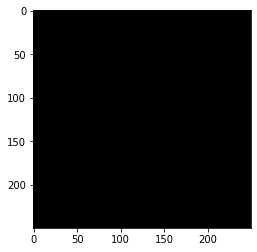

In [65]:
c.show()

In [4]:
def _get_corner_points(image):
    # Utility function to check whether the augmentations where performed
    # expects batch of image - expected shape is [s,x,y,c]
    return image[:, [0, -1], :, :][:, :, [0, -1], :]

In [1]:
class Checker:
    def __init__(self, resolution, tile_size):
        #Initilize
        self.resolution = resolution
        self.tile_size = tile_size
        self.output = np.zeros((self.resolution,self.resolution)) #create canvas
        
    def draw(self):
        indices = np.indices((self.resolution//self.tile_size, self.resolution//self.tile_size)) #get index for each coordinate
        tile_sum = indices[0] + indices[1] 
        checkers_bool = tile_sum % 2 != 0 #mask alternate elements
        checkers_array = checkers_bool.astype(int)
        scale_factor = self.resolution//checkers_array.shape[0] #scale array to checkboard resolution
        self.output = np.kron(checkers_array, np.ones((scale_factor, scale_factor))).astype(int) #scale using Kronecker product of two arrays
        
        return self.output.copy()
    
    def show(self):
        plt.imshow(self.output, cmap='gray') #show
        plt.show()

In [16]:
c = Checker(250,25)

In [18]:
c.draw()

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

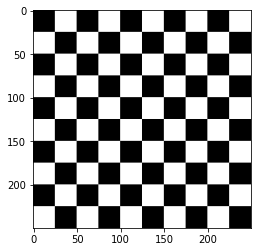

In [19]:
c.show()